# Compute a single map from runs 7430 to 7435

### Author:  JJGC

#### STM maps

-Uses about 4 M events (runs out of memory in MAC for larger sample)
-Compute a single-time map which can then be used to correct geometry

### Software: KrCalib : https://github.com/nextic/ICAROS/

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Sun Aug 25 12:37:40 2019


### Logger

In [2]:
import logging


logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')


2019-08-25 12:37:40,349 | INFO : Hello world!


### Input files

In [3]:
from krcal.core.kr_types import KrFileName
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

run_i = 7430
run_f = 7435

input_file_names  = ['dst_7430_trigger1_0000_7615.h5',
                     'dst_7431_trigger1_0000_9066.h5',
                     'dst_7432_trigger1_0000_9095.h5',
                     'dst_7433_trigger1_0000_8920.h5',
                     'dst_7435_trigger1_0000_8898.h5']

time_bins = 20
xybins    = 100
output_file_name  = ' '
map_file_name     = f'kr_maps_xy_{run_i}_{run_f}.h5'
map_file_name_ts  = f'kr_maps_rphi_5_8_ts_{time_bins}_7430_7435.h5'
emap_filename     = f'kr_emap_xy_{xybins}_{xybins}_r_{run_i}_{run_f}.h5'


krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_filename)

### Notebook configuration

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

In [6]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.io.dst_io              import load_dst
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units
import invisible_cities.reco.corrections      as corrf

In [7]:
import krcal.dev.corrections                  as corrections 
import krcal.utils.hst_extend_functions       as hst
from krcal.core import fit_functions_ic       as fitf
import invisible_cities.reco.corrections      as corrf

In [8]:
from krcal.core.io_functions       import filenames_from_paths
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import kdst_write
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_maps_ts
from krcal.core.io_functions       import read_maps_ts


In [9]:
from krcal.core.ranges_and_bins_functions     import kr_ranges_and_bins
from krcal.core.histo_functions               import h1, h1d, h2, h2d, profile1d, plot_histo
from krcal.core.kr_types                      import PlotLabels, FitType


In [10]:
from krcal.core.core_functions      import time_delta_from_time
from krcal.core.core_functions      import phirad_to_deg
from krcal.core.core_functions      import NN
from krcal.core.core_functions      import timeit
from krcal.core.core_functions      import data_frames_are_identical
from krcal.core                     import fit_functions_ic as fitf

In [11]:
from krcal.core.plt_functions  import plot_sector
from krcal.core.plt_functions  import plot_sectors

In [12]:
from krcal.core.stat_functions      import mean_and_std

In [13]:
from krcal.core.selection_functions           import event_map_df
from krcal.core.selection_functions           import select_rphi_sectors_df
from krcal.core.selection_functions           import select_xy_sectors_df
from krcal.core.selection_functions           import get_time_series_df
from krcal.core.selection_functions           import selection_info
from krcal.core.selection_functions           import selection_in_band
from krcal.core.selection_functions           import plot_selection_in_band

from krcal.core.fitmap_functions              import time_fcs_df
from krcal.core.fitmap_functions              import fit_fcs_in_rphi_sectors_df
from krcal.core.fitmap_functions              import fit_map_xy_df

from krcal.core.map_functions                 import tsmap_from_fmap
from krcal.core.map_functions                 import amap_from_tsmap
from krcal.core.map_functions                 import relative_errors
from krcal.core.map_functions                 import amap_average
from krcal.core.map_functions                 import amap_max
from krcal.core.map_functions                 import amap_min
from krcal.core.map_functions                 import amap_replace_nan_by_mean
from krcal.core.map_functions                 import amap_replace_nan_by_zero
from krcal.core.map_functions                 import regularize_maps
from krcal.core.map_functions                 import get_maps_from_tsmap
from krcal.core.map_functions                 import map_average
from krcal.core.map_functions                 import add_mapinfo

from krcal.core.xy_maps_functions             import draw_xy_maps
from krcal.core.xy_maps_functions             import draw_xy_map
from krcal.core.xy_maps_functions             import draw_xy_maps_ts

from krcal.core.rphi_maps_functions           import draw_rphi_maps
from krcal.core.rphi_maps_functions           import draw_rphi_map
from krcal.core.rphi_maps_functions           import draw_rphi_maps_ts
from krcal.core.rphi_maps_functions           import draw_wedges
from krcal.core.rphi_maps_functions           import define_rphi_sectors
from krcal.core.rphi_maps_functions           import rphi_sector_map_def

from krcal.core.correction_functions          import e0_rphi_correction
from krcal.core.correction_functions          import e0_xy_correction
from krcal.core.correction_functions          import lt_xy_correction
from krcal.core.correction_functions          import e0_xy_correction_ts
from krcal.core.correction_functions          import lt_xy_correction_ts
from krcal.core.correction_functions          import lt_rphi_correction
from krcal.core.correction_functions          import lt_rphi_correction_ts
from krcal.core.correction_functions          import e0_rphi_correction_ts
from krcal.core.correction_functions          import e0_rphi_correction_ts

from krcal.core.fit_lt_histograms             import plot_time_fcs
from krcal.core.fit_energy_functions          import fit_energy
from krcal.core.fit_energy_functions          import plot_fit_energy
from krcal.core.fit_energy_functions          import print_fit_energy
from krcal.core.fit_energy_functions          import resolution_r_z
from krcal.core.fit_energy_functions          import plot_resolution_r_z



In [14]:
from krcal.core.fit_lt_functions    import fit_lifetime
from krcal.core.fit_lt_functions    import time_fcs
from krcal.core.fit_lt_functions    import fit_fcs_in_rphi_sectors
from krcal.core.fit_lt_functions    import fit_fcs_in_xy_bin
from krcal.core.fit_lt_functions    import fit_map_rphi
from krcal.core.fit_lt_functions    import fit_map_xy
from krcal.core.fit_lt_functions    import get_time_series

In [15]:
from krcal.core.fit_lt_histograms   import histo_fit_sectors
from krcal.core.fit_lt_histograms   import print_fit_sectors_pars
from krcal.core.fit_lt_histograms   import plot_fit_sectors
from krcal.core.fit_lt_histograms   import plot_fit_xy
from krcal.core.fit_lt_histograms   import plot_time_fcs
from krcal.core.fit_lt_histograms   import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_histograms   import print_fit_lifetime

In [16]:
from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z

In [17]:
from krcal.core.kr_types import PlotLabels, KrEvent, ASectorMap
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core.kr_types import KrFileName


In [18]:
from krcal.core.rphi_maps_functions   import draw_rphi_maps
from krcal.core.rphi_maps_functions   import draw_rphi_map
from krcal.core.rphi_maps_functions   import draw_rphi_maps_ts
from krcal.core.rphi_maps_functions   import draw_wedges
from krcal.core.rphi_maps_functions   import define_rphi_sectors
from krcal.core.rphi_maps_functions   import rphi_sector_map_def

In [19]:
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import amap_valid_mask
from krcal.core.map_functions   import amap_valid_fraction
from krcal.core.map_functions   import amap_average
from krcal.core.map_functions   import amap_max
from krcal.core.map_functions   import amap_min
from krcal.core.map_functions   import amap_replace_nan_by_mean
from krcal.core.map_functions   import amap_replace_nan_by_zero
from krcal.core.map_functions   import regularize_maps
from krcal.core.map_functions   import get_maps_from_tsmap
from krcal.core.map_functions   import map_average

In [20]:
from krcal.core.xy_maps_functions   import draw_xy_maps
from krcal.core.xy_maps_functions   import draw_xy_map
from krcal.core.xy_maps_functions   import draw_xy_maps_ts

In [21]:
from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

In [22]:
from krcal.core.correction_functions import e0_rphi_correction
from krcal.core.correction_functions import e0_xy_correction
from krcal.core.correction_functions import lt_xy_correction
from krcal.core.correction_functions import e0_xy_correction_ts
from krcal.core.correction_functions import lt_xy_correction_ts
from krcal.core.correction_functions import lt_rphi_correction
from krcal.core.correction_functions import lt_rphi_correction_ts
from krcal.core.correction_functions import e0_rphi_correction_ts

In [23]:
from numpy import pi, sqrt

In [24]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [25]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Logger


- CRITICAL
- ERROR
- WARNING
- INFO
- DEBUG



In [26]:
log = logging.getLogger()

### Input/output 

In [27]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)

In [28]:
fn

KrFileName(input_file_names=['/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_7430_trigger1_0000_7615.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_7431_trigger1_0000_9066.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_7432_trigger1_0000_9095.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_7433_trigger1_0000_8920.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_7435_trigger1_0000_8898.h5'], output_file_name='/Users/jjgomezcadenas/Projects/ICDATA/ldst/ ', map_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_xy_7430_7435.h5', map_file_name_ts='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_rphi_5_8_ts_20_7430_7435.h5', emap_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_xy_100_100_r_7430_7435.h5')

In [29]:
def load_dsts(dst_list, group, node):
    dsts = [load_dst(filename, group, node) for filename in dst_list]
    return pd.concat(dsts, ignore_index=True)


In [30]:
dst           = load_dsts(fn.input_file_names, "DST", "Events")

In [31]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {len(dst)}")

Total number of events: 2316147


In [32]:
dst.head()

,index,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,...,Z,Zrms,X,Y,R,Phi,Xrms,Yrms,E0,E
0,2,2,1.565276e+09,0,0,1,1,125.0,2.173434,7.521394,...,373.881958,1.901097,146.720090,7.963220,146.936033,0.054222,9.697072,9.861699,12156.770562,12924.308246
1,10,15,1.565276e+09,0,0,1,1,425.0,0.874476,10.297514,...,260.050568,1.556588,-4.459044,-134.780043,134.853784,-1.603868,10.056039,11.245365,12146.150316,12676.166465
2,15,21,1.565276e+09,0,0,1,1,250.0,0.852809,6.603673,...,160.810440,1.257667,24.829080,-37.860246,45.275616,-0.990348,8.349519,7.781161,12257.811442,12532.292743
3,16,22,1.565276e+09,0,0,1,1,325.0,3.652303,21.043337,...,480.764099,2.093034,98.101895,134.563100,166.526904,0.940845,9.169067,10.539603,11620.957543,12626.921145
4,43,38,1.565276e+09,0,0,1,1,275.0,2.195430,10.667283,...,22.795752,0.572101,86.262573,54.622085,102.101928,0.564479,8.359329,8.043520,12738.335121,12827.149923


In [33]:
dst.tail()

,index,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,...,Z,Zrms,X,Y,R,Phi,Xrms,Yrms,E0,E
2316142,310,2741302,1.565781e+09,0,0,1,1,175.0,1.898998,10.091793,...,57.805878,0.798758,-121.978835,75.089693,143.238606,2.589784,50.288165,47.155776,12153.122750,12337.796025
2316143,318,2740747,1.565781e+09,0,0,1,1,200.0,2.406047,13.402755,...,425.702698,2.047230,0.928500,-79.943817,79.949209,-1.559182,29.210081,19.500292,12166.574800,12871.761665
2316144,321,2741314,1.565781e+09,0,0,1,1,325.0,0.989356,8.931018,...,125.709572,1.122172,-2.048726,94.407129,94.429356,1.592494,8.644183,8.176058,12308.310842,12639.490281
2316145,322,2740753,1.565781e+09,0,0,1,1,250.0,3.862249,18.172167,...,217.659317,1.553734,84.528731,70.730504,110.217560,0.696759,9.453211,8.415939,12423.530688,12825.235075
2316146,346,2740769,1.565781e+09,0,0,1,1,150.0,2.807300,11.458026,...,468.581787,2.193079,-88.611833,141.388508,166.861521,2.130636,8.570523,9.734894,11567.114080,12490.936423


In [34]:
dst.index

RangeIndex(start=0, stop=2316147, step=1)

### Ranges and binning

In [35]:
RMAX      = 200
RFID      = 180
RCORE     = 100
s1e_range = (3, 25)
s2e_range = (2000, 20000)
s2q_range = (100, 1000)

xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range   = s2e_range
lt_range  = (1000, 11000)
c2_range  = (0,5)
time_bins = 1

In [36]:
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = xybins,
                                                        ynbins    = xybins,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [37]:
krRanges

KrRanges(S2e=(2000, 20000), S1e=(3, 25), S2q=(100, 1000), X=(-200, 200), Y=(-200, 200), Z=(10, 550), T=(1565275938.9490001, 1565780942.2680001))

In [38]:
krNbins

KrNBins(S2e=25, S1e=10, S2q=25, X=100, Y=100, Xsi=50, Ysi=50, Z=15, T=140)

In [39]:
dstx     = dst[in_range(dst.X, -RMAX, RMAX)]
dst      = dstx[in_range(dstx.Y, -RMAX, RMAX)]
dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)
dst = dst.assign(DT=DT)
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms', 'E0', 'E'],
      dtype='object')

In [40]:
dst.DT.head()

0    0.000
1    0.434
2    0.522
3    0.538
4    1.266
Name: DT, dtype: float64

In [41]:
dst.DT.tail()

2316142    505002.083
2316143    505002.181
2316144    505002.897
2316145    505003.045
2316146    505003.319
Name: DT, dtype: float64

### Time 

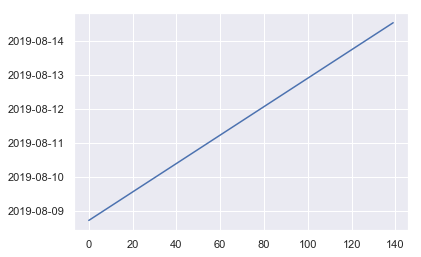

In [42]:
plt.plot(krTimes.timeStamps)

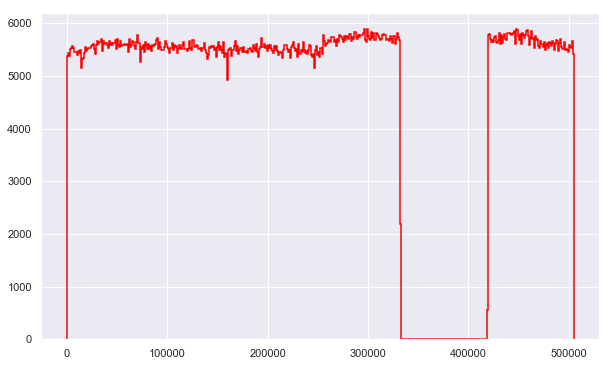

In [43]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(dst.DT.values, bins=500, range = (dst.DT.values[0], dst.DT.values[-1]), color='red', stats=False, lbl='pre-sel')

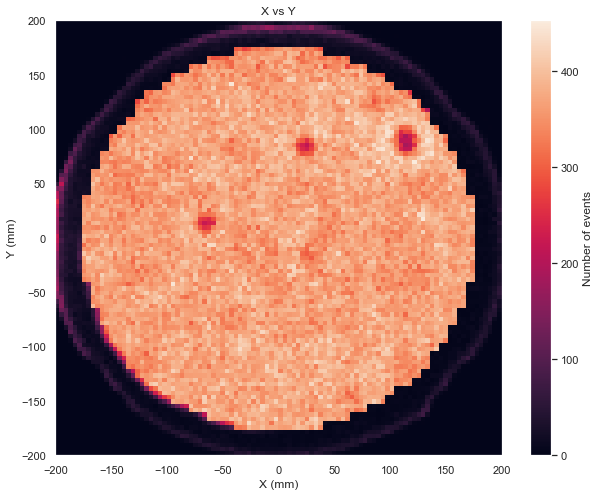

In [44]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, (-200,200), (-200,200), 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

## Time series

In [45]:
time_bins = 8
ti = timeit(get_time_series_df)
ts, masks = ti(time_bins, (DT[0],DT[-1]), dst)
ts

Time spent in get_time_series_df: 0.04005718231201172 s


array([ 31562.7074375 ,  94688.1223125 , 157813.5371875 , 220938.9520625 ,
       284064.3669375 , 347189.7818125 , 410315.1966875 , 473440.61156251])

In [46]:
ti = timeit(time_fcs_df)
fps = ti(ts, masks, dst, 
         nbins_z = 15,
         nbins_e = 25,
         range_z = (10, 550),
         range_e = (7000, 18000),
         energy  = 'S2e',
         fit     = FitType.profile)

Time spent in time_fcs_df: 0.57411789894104 s


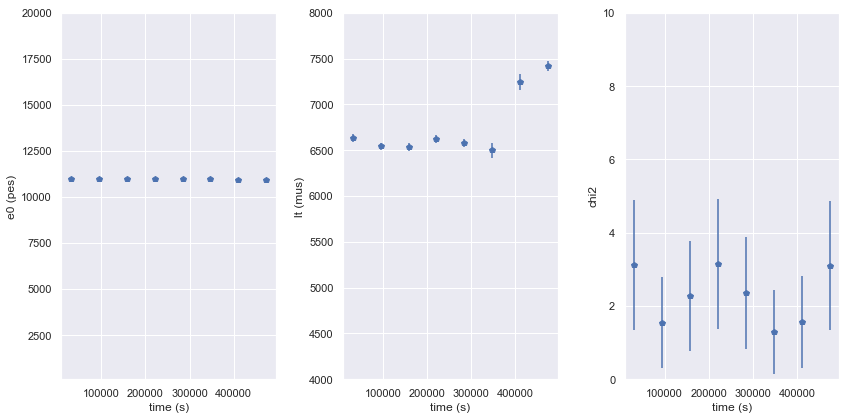

In [47]:
plot_time_fcs(fps,
              range_chi2  = (0,10),
              range_e0    = (100,20000),
              range_lt    = (4e+3, 8e+3),
              figsize     = (12,6))

### This shows that lifetime jumps starting at 4e+5 (last run). Therefore is better to join first 4 runs only. Nevertheless we will produce a map with the 5 runs and compare the effect of the lifetime jump wrt using only 4

# XY map

In [48]:
ti = timeit(select_xy_sectors_df)
KXY = ti(dst, krBins.X, krBins.Y)

Time spent in select_xy_sectors_df: 10.375912189483643 s


In [49]:
nXY = event_map_df(KXY)

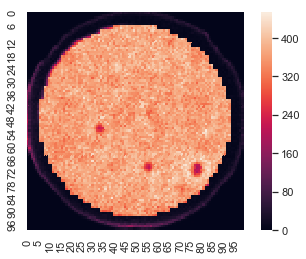

In [50]:
ax = sns.heatmap(nXY, square=True)

In [51]:
ti = timeit(fit_map_xy_df)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fmxy = ti(selection_map = KXY,
              event_map      = nXY,
              n_time_bins    = 1,
              time_diffs     = DT,
              nbins_z        = krNbins.Z, 
              nbins_e        = krNbins.S2e, 
              range_z        = z_range, 
              range_e        = e_range,
              energy         = 'S2e',
              z              = 'Z',
              fit            = FitType.unbined,
              n_min          = 100)

Time spent in fit_map_xy_df: 20.427032947540283 s


In [52]:
ti = timeit(tsmap_from_fmap)
tsm = ti(fmxy)

Time spent in tsmap_from_fmap: 0.013151884078979492 s


In [53]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

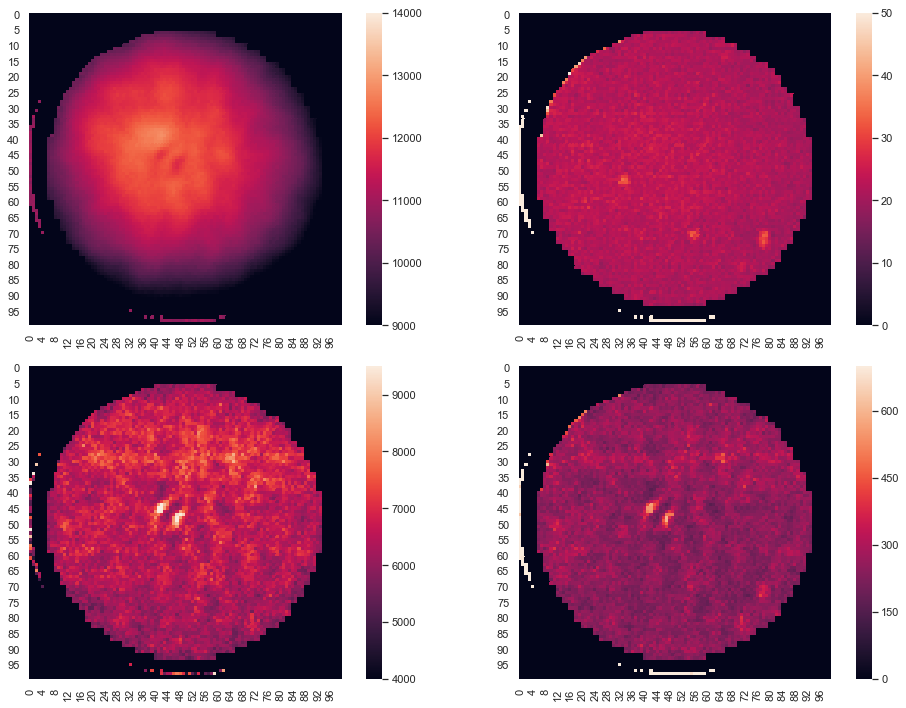

In [54]:
draw_xy_maps(am,
            e0lims  = (9000, 14000),
            ltlims  = (4000, 9500),
            eulims  = (0.0,  50),
            lulims  = (0, 700),
            figsize=(14,10))

In [55]:
amap_average(am) 

ASectorMap(chi2=1.0945035785705943, e0=10824.599605289173, lt=6531.498485272228, e0u=26.452949486421378, ltu=335.120483950809, mapinfo=None)

In [56]:
rmap = regularize_maps(am, erange=e_range, ltrange=lt_range)

2019-08-25 12:38:27,469 | INFO :  set nans to average value of interval = 11000.0
2019-08-25 12:38:27,558 | INFO :  set nans to average value of interval = 6000.0


In [57]:
amap_average(rmap)

ASectorMap(chi2=1.0945035785705943, e0=10824.599605289173, lt=6529.428520038861, e0u=26.452949486421378, ltu=334.1177051774929, mapinfo=None)

In [58]:
asm = relative_errors(rmap)

In [59]:
amv = amap_average(asm)
amv

ASectorMap(chi2=1.0945035785705943, e0=10824.599605289173, lt=6529.428520038861, e0u=0.24517295968462752, ltu=5.098959505876434, mapinfo=None)

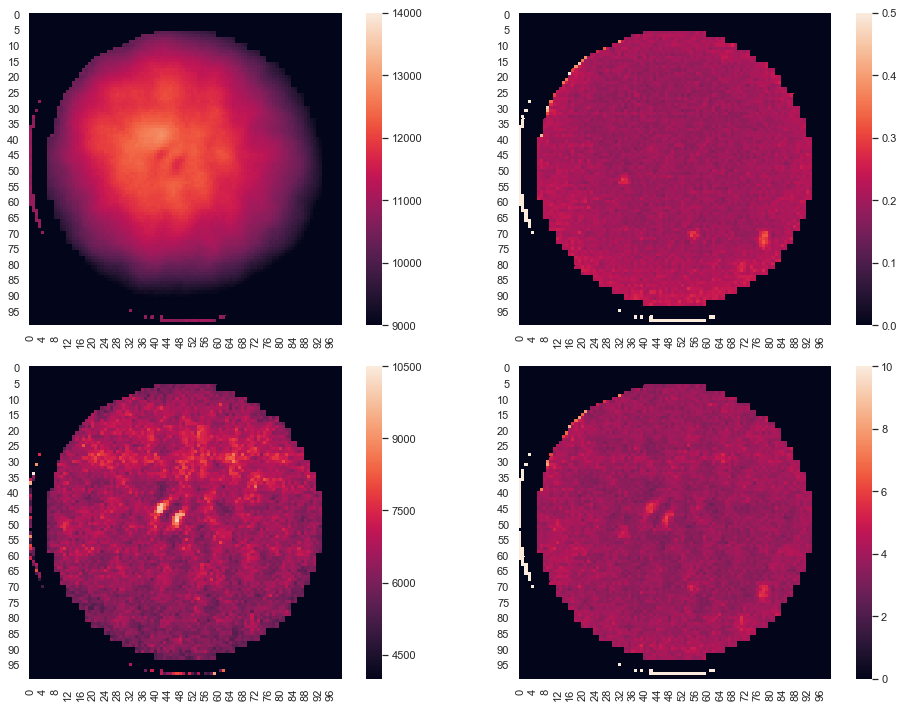

In [60]:
draw_xy_maps(asm,
            e0lims  = (9000, 14000),
            ltlims  = (4000, 10500),
            eulims  = (0.0,  0.5),
            lulims  = (0, 10),
            figsize=(14,10))

## Notice the two bright spots in the center of the chamber!

## Write maps

In [61]:
asmAv = amap_replace_nan_by_mean(asm, amMean=amv)
amap_average(asmAv)

ASectorMap(chi2=0.9930904387769537, e0=10909.15154000188, lt=6553.787562491674, e0u=0.22527379443241458, ltu=4.494207243777158, mapinfo=None)

In [62]:
asm = add_mapinfo(asmAv, krRanges.X, krRanges.Y, krNbins.X, krNbins.Y, run_number=f'{run_i}')

In [63]:
asm.mapinfo

xmin          -200
xmax           200
ymin          -200
ymax           200
nx             100
ny             100
run_number    7430
dtype: object

In [64]:
print(f'writing emaps in {emap_filename}')
write_maps(asm, filename=emap_filename)

writing emaps in kr_emap_xy_100_100_r_7430_7435.h5


/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


## Read back and check resolution

In [65]:
emaps = read_maps(filename=emap_filename)

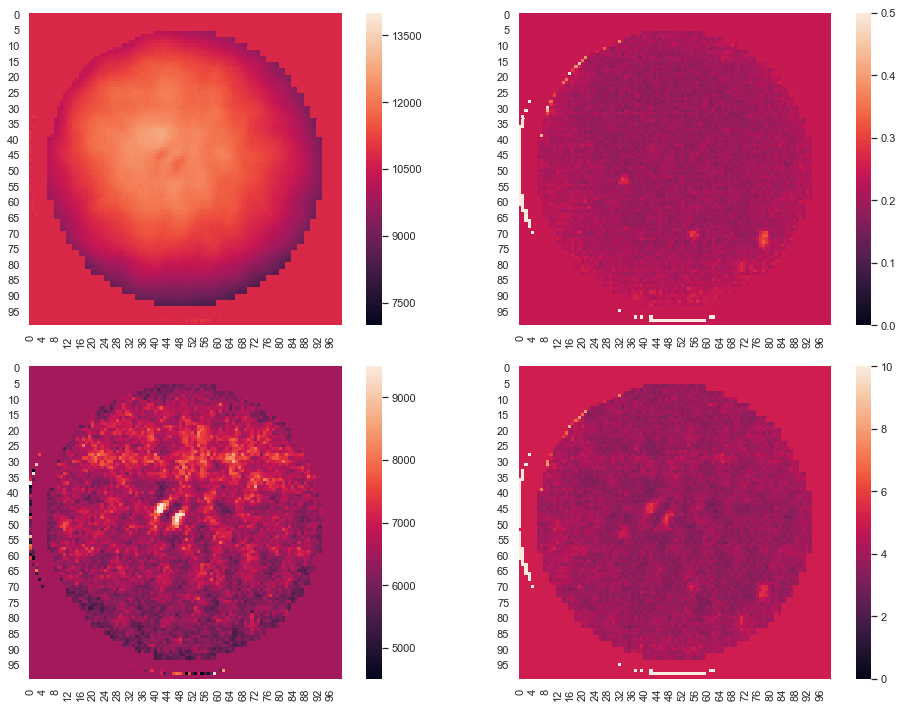

In [66]:
draw_xy_maps(emaps,
            e0lims  = (7000, 14000),
            ltlims  = (4500, 9500),
            eulims  = (0.0,  0.5),
            lulims  = (0, 10),
            figsize=(14,10))

In [67]:
amap_average(emaps)

ASectorMap(chi2=0.9930904387769537, e0=10909.15154000188, lt=6553.787562491674, e0u=0.22527379443241458, ltu=4.494207243777158, mapinfo=None)

In [68]:
norm = amap_max(emaps)
norm

ASectorMap(chi2=52.405307687838594, e0=12852.316943975737, lt=10780.465565062368, e0u=1.4651058633044842, ltu=47.493286326472244, mapinfo=None)

In [69]:
ti = timeit(e0_xy_correction)
E0 = ti(dst.S2e.values,
        dst.X.values,
        dst.Y.values,
        E0M = emaps.e0 / norm.e0, 
        xr  = krRanges.X,
        yr  = krRanges.Y,
        nx  = krNbins.X, 
        ny  = krNbins.Y)

Time spent in e0_xy_correction: 18.966480016708374 s


In [70]:
ti = timeit(lt_xy_correction)
E = ti(E0, 
       dst.X.values, 
       dst.Y.values,
       dst.Z.values, 
       LTM = emaps.lt,
       xr  = krRanges.X,
       yr  = krRanges.Y,
       nx  = krNbins.X, 
       ny  = krNbins.Y)

Time spent in lt_xy_correction: 18.627846717834473 s


## Now compare the corrected energy with the new map (E) with the single-map corrected energy (E)

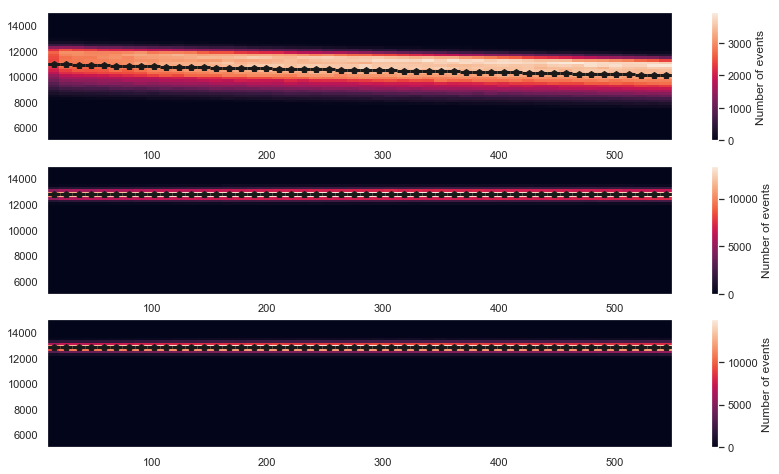

In [71]:
er = (5000,15000)
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(3, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 2)
nevt = h2(dst.Z, dst.E, 50, 50, krRanges.Z, er, 
           profile=True)
ax      = fig.add_subplot(3, 1, 3)
nevt = h2(dst.Z, E, 50, 50, krRanges.Z, er, 
           profile=True)

## Individual correction

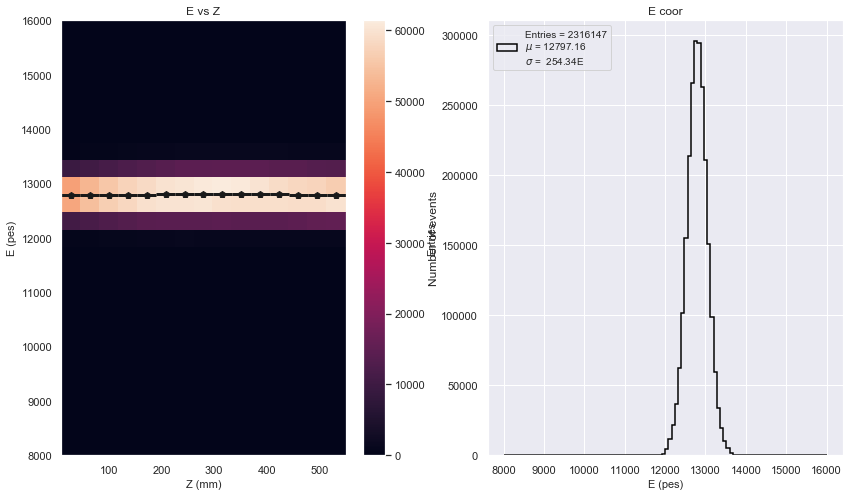

In [72]:
e_range = (8000,16000)
zrange = (10,550)
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.Z, dst.E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(dst.E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

## Global map correction

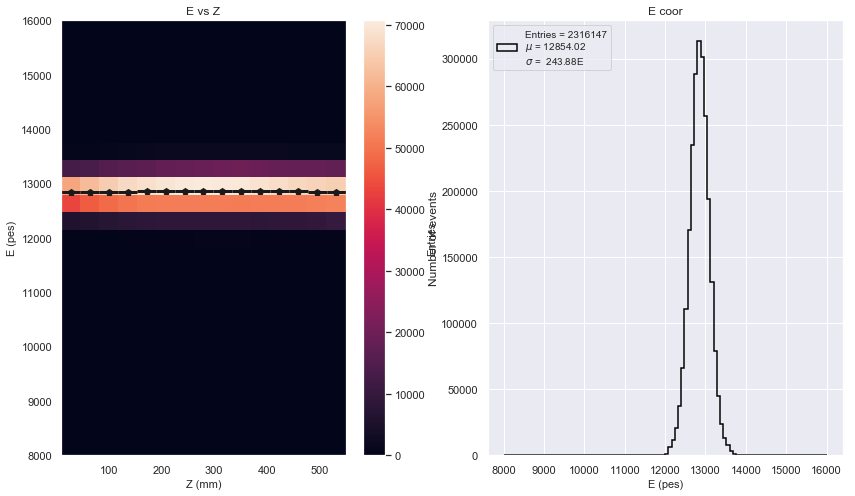

In [73]:
e_range = (8000,16000)
zrange = (10,550)
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.Z, E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

### Some improvement!

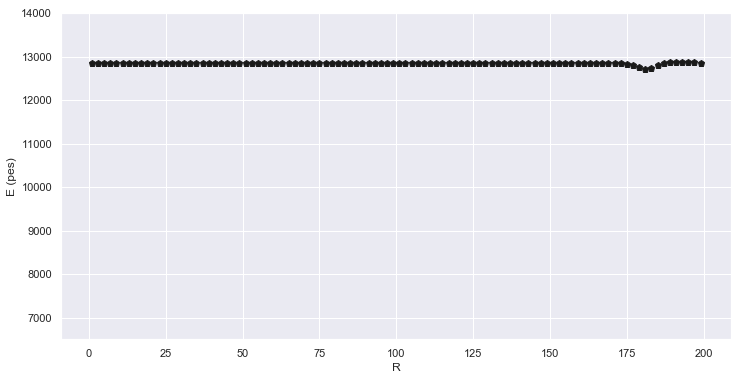

In [74]:
energy_X_profile(dst.R, E, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=(6500, 14000),  
                 figsize=(12,6))

In [75]:
dst = dst.assign(EC=E)

In [76]:
RFID2 = 170
dst_R     = dst[dst.R < RFID2]

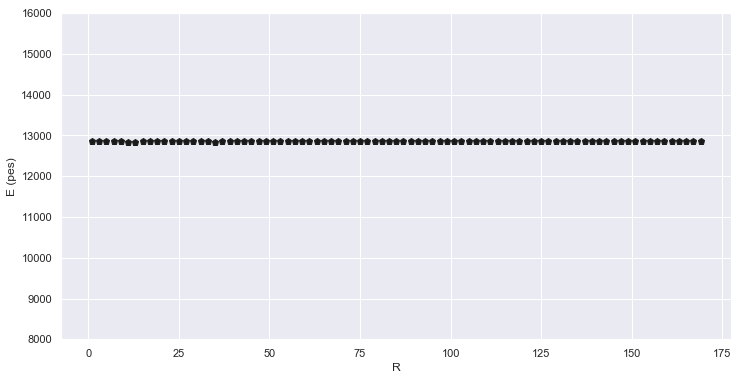

In [77]:
energy_X_profile(dst_R.R, dst_R.EC, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=e_range,  
                 figsize=(12,6))

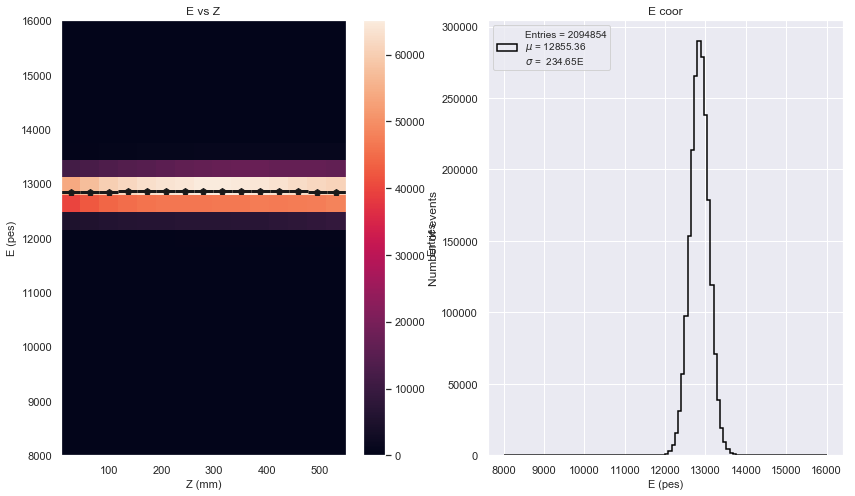

In [78]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst_R.Z, dst_R.EC, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(dst_R.EC,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12855.4464381156 +-0.16330981046726495 
 E sigma   = 232.67805152389133 +-0.12530683475147436 
 chi2    = 4.630606733566466 
 sigma E/E (FWHM)     (%) =4.253398928721262
 sigma E/E (FWHM) Qbb (%) =0.5493347927561468 


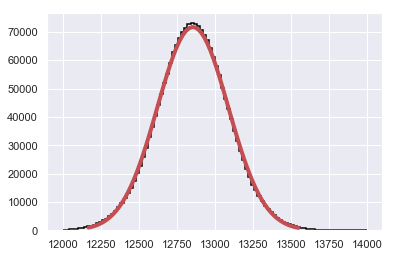

In [79]:
fc = fit_energy(dst_R.EC, nbins=100, range=(12000, 14000))
plot_fit_energy(fc)
print_fit_energy(fc)

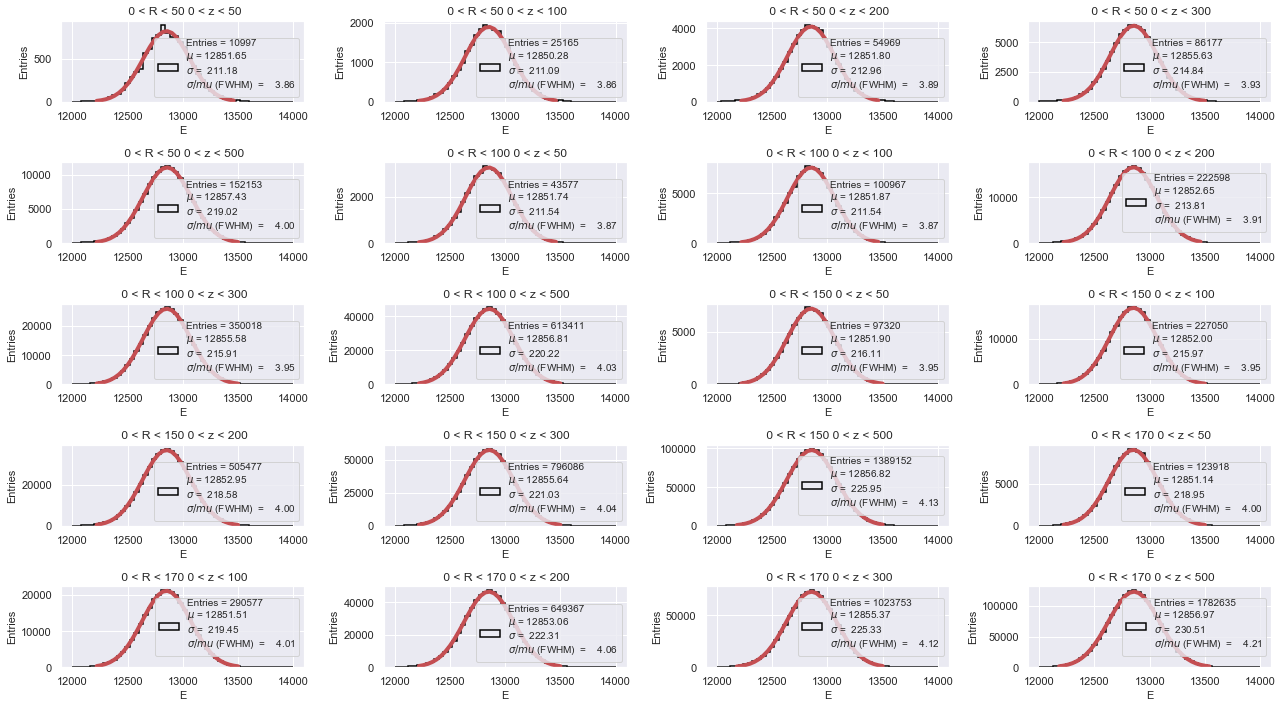

In [80]:
Ri = (50, 100,150,170)
Zi = (50, 100,200,300,500)

FC, FCE = resolution_r_z(Ri, Zi, dst_R.R, dst_R.Z, dst_R.EC,
                    enbins = 50,
                    erange = (12000,14000),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10)) 

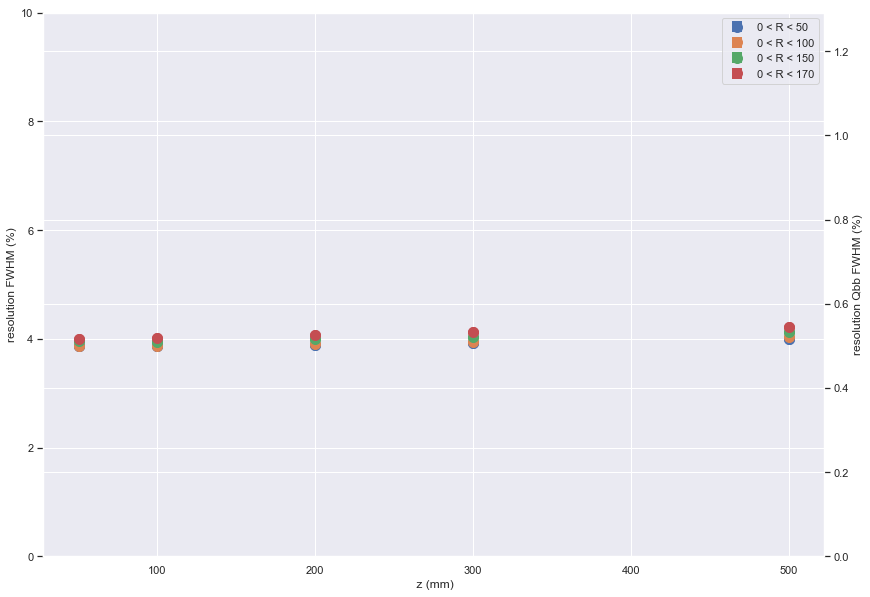

In [81]:
plot_resolution_r_z(Ri, Zi, FC, FCE, r_range=(0,10))

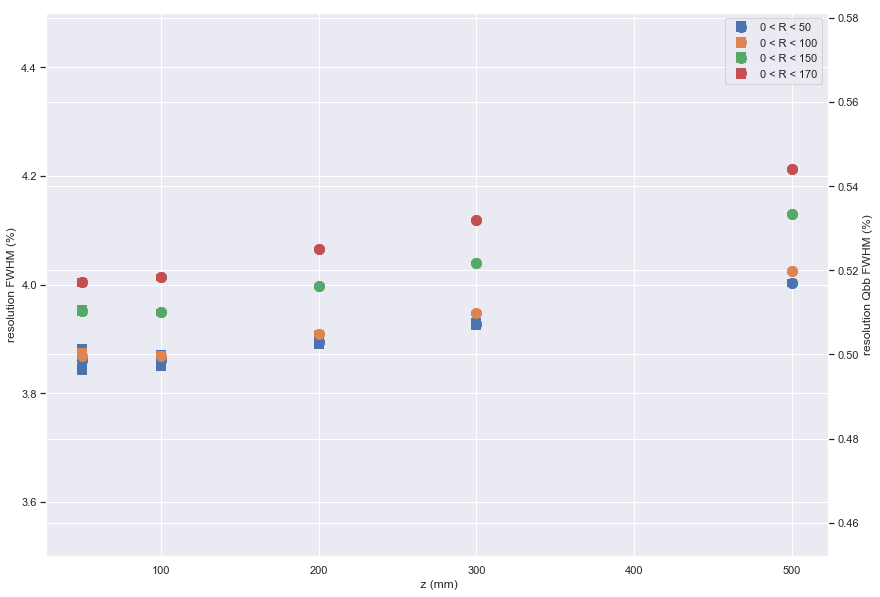

In [82]:
plot_resolution_r_z(Ri, Zi, FC, FCE, r_range=(3.5,4.5))